# Assignment #5 - Deep Learning  (Extra Credits)
<font color="red"> DUE: Dec 7 (Monday) 11:00 pm </font>  

<font color="blue"> Yike Li </font>

Contents
 
1. Overview
2. Data
3. Method 
4. Result
5. Conclusion
6. Refrences


# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

The objective of this assignment is to implement deep learning models to solve ML problems. We continue to use the regression data in Assignment 1 for this task. First, we visualize the data. Thereafter, we partition the data based on training, validation and test sets. We use Tensorflow and the its Keras API to build deep neural networks and try on 3 different network structures in attempt to achieve best out-of-sample performance. 

# II. Data (Regression)

This dataset comes from the load forecasting track of GEFCom2012 (Global Energy Forecasting Competition). During the competition, contestants were asked to forecast and backcast the electricity demand for 21 load zones, of which the Zone 21 was the sum of the other 20 zones. The entire data set consists of hourly load data of 20 zones from the 1st hour of 1/1/2004 to the 6th hour of 6/30/2008, with hourly temperature history from 11 anonymous weather stations ($T_1$-$T_{11}$). Since the dataset is huge, in this assignment, I only conduct the EDA using the Zone 11 data. 

Further details about GEFCom2012 can be found in this [link](http://blog.drhongtao.com/2016/07/gefcom2012-load-forecasting-data.html). 

In [2]:
# import
import numpy as np
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

register_matplotlib_converters()

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
# !ls "/content/drive/My Drive/" # check drive file names

Mounted at /content/drive/


In [4]:
# Load the regression dataset, GEFCOM2012 load forecasting track, loads are in GW
zone_21 = pd.read_excel('/content/drive/My Drive/Colab Notebooks/GEFCom2012_zone 21.xlsx')

Here is how the dataset looks like, as well as the some of the basic statistics. This dataset is pre-cleaned and thus is ready for data visualization.

In [5]:
zone_21.head(3)

,zone_id,year,month,day,hour,load,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,weekday,date,T_ave
0,21,2004,1,1,1,1.397668,46,38,44,45,42,44,45,43,41,42,36,5,2004-01-01 00:00:00,42.363636
1,21,2004,1,1,2,1.351507,46,36,42,43,42,43,44,44,39,43,32,5,2004-01-01 01:00:00,41.272727
2,21,2004,1,1,3,1.315742,45,35,40,41,40,42,41,42,36,43,31,5,2004-01-01 02:00:00,39.636364


In [6]:
zone_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   zone_id  35064 non-null  int64         
 1   year     35064 non-null  int64         
 2   month    35064 non-null  int64         
 3   day      35064 non-null  int64         
 4   hour     35064 non-null  int64         
 5   load     35064 non-null  float64       
 6   T1       35064 non-null  int64         
 7   T2       35064 non-null  int64         
 8   T3       35064 non-null  int64         
 9   T4       35064 non-null  int64         
 10  T5       35064 non-null  int64         
 11  T6       35064 non-null  int64         
 12  T7       35064 non-null  int64         
 13  T8       35064 non-null  int64         
 14  T9       35064 non-null  int64         
 15  T10      35064 non-null  int64         
 16  T11      35064 non-null  int64         
 17  weekday  35064 non-null  int64 

Below shows the statistics (mean, standard deviation, minimum and maximum) of temperature recorded at each station. It can be seen the temperature values vary a wide range, particularly for the minimum temperature. The temperature is in the unit of Fahrenheit.

In [7]:
# Observe the temperature reported at each station
temperature_2012 = zone_21.iloc[:, 6:-3]
desc = temperature_2012.describe().loc[['mean', 'std', 'min', 'max']]
print(desc.T)

          mean        std   min    max
T1   59.779689  16.786408  12.0  103.0
T2   54.944587  17.441852   0.0   95.0
T3   56.199264  17.647732   8.0   98.0
T4   60.249914  17.417561  11.0  103.0
T5   56.873175  17.654845   6.0   99.0
T6   58.847450  17.092306   7.0  103.0
T7   58.983801  18.044259   8.0  104.0
T8   59.331679  17.777466   6.0  103.0
T9   56.806097  17.997679   5.0  100.0
T10  58.934577  17.427423   5.0  102.0
T11  55.106206  17.967747   0.0   98.0


Three years (2004-2006) of the hourly load plot at the aggregated load zone - $Z_{21}$ and hourly temperature plot obtained from the average of 11 temperature series, are plotted. We see very strong yearly seasonality for both the Load (up) and the Temperature (down). 

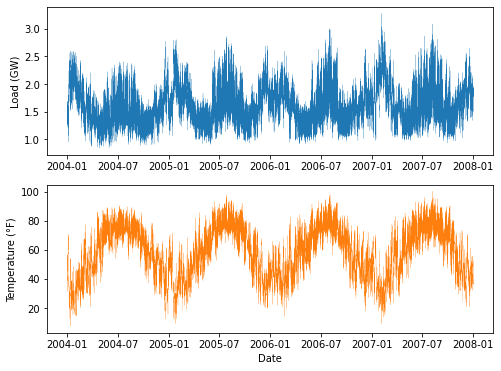

In [8]:
# 2012 Hourly Load and Temperature curve
plt.figure(figsize=(8, 6))
plt.subplot(211)  # Hourly load plot
plt.plot(zone_21.date, zone_21.load, lw=.2)
plt.ylabel('Load (GW)')
plt.subplot(212)  # Hourly temperature plot
plt.plot(zone_21.date, zone_21.T_ave, lw=.2, c='tab:orange')
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')
plt.show()

Temperature is known to have a strong correlation with electricity usage patterns. Below shows the scatterplot of load – temperature relationship using three years of data (2004-2006) from the $Z_{21}$ and the average temperature from the 11 stations. The graph shows a strong correlation (the typical “hockey stick” shape) between the load and temperature. On the left arm, the load goes up for heating needs during the winter when the temperature drops below a certain point. On the right arm, the load goes up for cooling needs during the summer when the temperature increases. This scatterplot shows that there is a cutoff point at around 60 °F.

Also a third order polynomial line is fitted in the plot. 

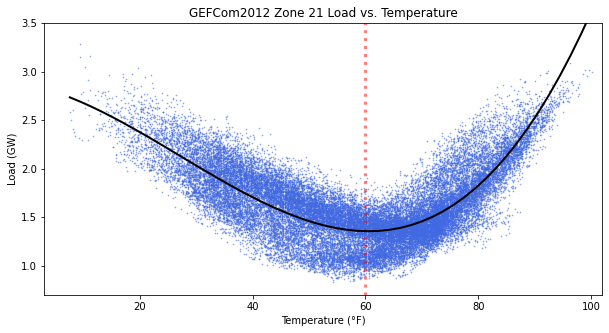

In [9]:
# 2012 Load vs. Temperature w/ fitted curve
from numpy.polynomial.polynomial import polyfit, polyval

plt.figure(figsize=(10, 5))
plt.scatter(zone_21.T_ave, zone_21.load, s=0.5,
            alpha=0.5, marker="o", c='royalblue')
plt.axvline(x=60, color='red', linestyle=':', alpha=0.5,
            linewidth=3)  # vertical dotted line
plt.title('GEFCom2012 Zone 21 Load vs. Temperature')
coefs = polyfit(zone_21.T_ave, zone_21.load, 3)  # fit 3rd order polynomial
x_new = np.linspace(min(zone_21.T_ave), np.max(zone_21.T_ave))
ffit = polyval(x_new, coefs)
plt.plot(x_new, ffit, '-', c='black', linewidth=2)
plt.xlim(3, 102)
plt.ylim(.7, 3.5)
plt.xlabel('Temperature (°F)')
plt.ylabel('Load (GW)')
plt.show()

To model the annual seasonality, the categorical variables – month, have been included to categorize load patterns throughout the year. The figure below gives the scatterplots of load – temperature relationship at each month of a year from the aggregated zone and the average temperature from the 11 stations in this case study. The correlation between the load and temperature during the winter months (Month=12, 1, 2, 3) and summer months (Month=6, 7, 8, 9) is stronger than the remaining months, largely due to during these 6 months, load tends to increase when the weather (temperature here) gets extreme. In the remaining 4 months (Month=4, 5, 10, 11), the relationship between the two is weak.

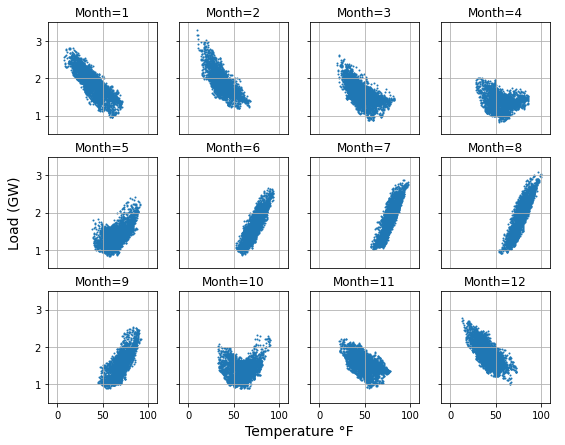

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=4, sharex='col',
                       sharey='row', figsize=(9, 7))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False,
                bottom=False, left=False, right=False)
# plt.rcParams['ytick.labelsize'] = 10
plt.xlabel('Temperature °F', fontsize=14)
plt.ylabel('Load (GW)', fontsize=14)
# fig.suptitle('Load vs. Temperature by Month')
for i in range(4):  # col
    for j in range(3):  # row
        ax[j, i].scatter(zone_21.loc[zone_21['month'] == i + j * 4 + 1].T_ave,
                         zone_21.loc[zone_21['month'] == i + j * 4 + 1].load, s=1)
        ax[j, i].set_title('Month=' + str(i + j * 4 + 1), fontsize=12)
        # set xlim and ylim for each subplot
        ax[j, i].set(xlim=(-10, 110), ylim=(0.5, 3.5))
        ax[j, i].grid(True)  # add gridlines
        if j != 2:
            ax[j, i].xaxis.set_ticks_position('none')  # remove xsticks
plt.show()

# III. METHODS 


In this assignment, you are building a deep network with more than 5 layers using TensorFlow. 
Looking at the chart below, get some idea about how you can construct your networks for what problem and why you pick your structure. 

- Pick at least 3 different networks for experiments.
- Summarize the choice of your networks. 
- Explain your TensorFlow (or Keras) codes. 
- Explain how you apply your model to your data. 

## Explanation of the choice for 3 different neural network structures and reason for the selection.

The input layer consists of various 51 features in X. Output layer only has one unit, namely the estimated load demand. We list the features we include in this network below:

Catogorical variables:
*   Hour of day (24 features)
*   Day of week (7 features)
*   Month of year (12 features)

Numerical variables:
*   Coincident temperature (1 feature)
*   Lagged hourly temperatures (3 features, indicating lagged temperatures up to 3 hours)
*   Lagged moving average temperatures (1 feature, indicating the lagged moving average temperature for up to 1 day)
*   Trend (1 feature): A natural increasing number. 

In the below experiments, we tried 3 different neural network structures listed below. The 3 network structures have roughly the same total amount of hidden neurons (~160). We want to explore that whether a "deeper" network can result in a better load forecasting performance. 

1.   5 fully-connected hidden layers. Each layer comes with 32 neurons. 
2.   6 fully-connected hidden layers. Each layer comes with 27 neurons. 
3.   7 fully-connected hidden layers. Each layer comes with 23 neurons. 

In the following 3 sections, we will use the `sequential` class in Keras to build our model, as it is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Some highlights and explaination of code that are common across the 3 networks are below:
-   We defined a function `recompile()` which takes the number of hidden layers and neurons in each layer as input and outputs the compiled DNN model. 
-   As we have 17520 training samples, we use a batch size of 32 to train all our networks, which results in total of 17520/32=548 batches. At each epoch, the algorithm will randomly pick a batch to calculate the gradient and update the weight. This can be treated as a mini-batch approach as the batch size is either too small (takes too much time to train and the converging behavior is too stochastic) or too large (may converge to local optimum). 
-   For each network, we shuffle the initial weights and repeat 5 times to minimize the risk of bad initialization.
-   We uniformly choose `selu` (Scaled Exponential Linear Units) as the activation function for the neurons in hidden layers. Similar to ReLUs, SELUs avoids vanishing gradients. In contrast to ReLUs, the neurons in a DNN using SELUs are always active and they are faster to train. Correspondingly, the `kernel_initializer` was set to 'lecun_normal'.
-   We uniformly choose `adam` with the default learning rate (0.001) as the optimizer as it is a popular algorithm to train DNNs and achieves good results fast. 
-   As we eventually will use MAPE to evaluate our forecasts, we choose it as the loss to minimize during our training steps.
-   We setup an early stopping rule to avoid overfitting during training and halt the training process at the right time. In `model.fit`, we set `epochs` as 300 and `patience` has been set to 30, meaning that the training will halt either if the model could not get better performance on the validation data within 30 epochs, or we have gone through a maximum of 300 epochs. At the end the training,  we get to keep the model when we reached the best performance on the validation data. 

In the following cell, we preprocess our data by following the steps below:


1.   Add a trend feature, which is a natural increasing number depicting the overall trend of load demand
2.   Conduct normalization for the data including the features and the target (load)
3.   Add lagged hourly temperatures and lagged moving avg temperature to the feature set
4.   Create dummy variables for the categorical features
5.   Partition the data into training, validation and test set. Given 4 years (2004-2007) historical load and temperature data, we use the first 2 years (2004-2005) as the training data which will be used to train the weights in DNN. We take the year 2006 as the validation data which will be used to inform the generalization performance of the current model and enforce the early stopping rule if neccesary. The final year 2007 will be used for testing to validation our model's out-of-sample performance.


In [11]:
#@title
df = zone_21[['year', 'month', 'hour', 'weekday', 'load', 'T_ave']].copy()
df.rename(columns={"T_ave": "T"}, inplace=True)


# Add trend column
def add_trend(data):
    """Add Linear trend to dataset. """
    data = data.reset_index(drop=True)  # reset index before concatenate
    trend = pd.Series(np.arange(1, len(data) + 1, 1, dtype=int), name='trend')
    return pd.concat([data, trend], axis=1)


df = add_trend(df)

# normalization
df['T'] = df['T'] / 100
df['trend'] = df['trend'] / len(df)
df['load'] = df['load'] / 3

hmax = 3  # max no. of lagged temperatures
dmax = 1  # max no. of lagged moving avg temperature
# get lagged hourly temperature
for i in range(1, hmax + 1):
    colname = 'Th_' + str(i)  # construct col name
    df[colname] = df['T'].shift(i)
# get lagged moving avg temperature.
for i in range(dmax):
    colname = 'Td_' + str(i + 1)  # construct col name
    df[colname] = df['T'].shift(1 + i * 24).rolling(window=24, min_periods=24).mean()

df = pd.get_dummies(df, columns=['month', 'hour', 'weekday'])
# df.shape

# Data partitioning
test = df[df['year'] == 2007].drop('year', axis=1)  # this is the test set
valid = df[df['year'] == 2006].drop('year', axis=1)  # this is the validation set
train = df[df['year'] < 2006].dropna().drop('year', axis=1)  # drop na rows. They are at beginning of training set

X_train, X_val, X_test, y_train, y_val, y_test = \
    train.drop('load', axis=1), valid.drop('load', axis=1), test.drop('load', axis=1), train.load, valid.load, test.load


## Network 1


The following cell gives the settings of our first network. We have 51 input neurons for 51 input features. we have 5 fully-connected hidden layers, each with 32 hidden neurons. We recompile the network 5 times to ensure different initial conditions have been tried out and each network will generate a forecast on the test year. At the end, we average the forecasts generated from the 5 different initial conditions. The rest settings have been following as mentioned in the previous cells. 

From the output of the following cell, we can tell that the training halts mostly at 50-100 epochs, even though we set the maximum epoch to be 300. After 50 epochs, the validation loss has rarely been reduced. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from datetime import datetime

n_input = len(X_train.columns) # 51
layer_num = 5
n_hidden_1 = 32  # node num of layer 1
n_hidden_2 = 32  # node num of layer 2 and beyond
num_repeat = 5
batch_size = 32
verbose = 0

def MAPE(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def recompile():
    model = Sequential()
    model.add(Dense(n_hidden_1, input_dim=n_input, activation='selu', kernel_initializer='lecun_normal'))
    for i in range(layer_num - 1):
        model.add(Dense(n_hidden_2, activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(1)) # output neuron
    model.compile(loss=mean_absolute_percentage_error, optimizer='adam')
    return model


mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    pred = saved_model.predict(X_test_pred)  # predict on test set using the snapshot 1 trained model
    pred = pred.reshape(24 * 365)
    pred_list.append(pred)

fcst_full = np.mean(pred_list, axis=0)  # compress(average) 10 rows into one row

Epoch 00089: early stopping
repeat time=1 MAPE on Training set: 3.400, MAPE on Validation set: 3.960
Epoch 00079: early stopping
repeat time=2 MAPE on Training set: 3.367, MAPE on Validation set: 3.934
Epoch 00057: early stopping
repeat time=3 MAPE on Training set: 3.825, MAPE on Validation set: 4.149
Epoch 00073: early stopping
repeat time=4 MAPE on Training set: 3.474, MAPE on Validation set: 4.005
Epoch 00120: early stopping
repeat time=5 MAPE on Training set: 3.121, MAPE on Validation set: 3.918


In the following cell, we evaluate our final forecast and get the MAPE performance on the training, validation and test set, respectively. 

In [ ]:
print(f'The MAPE on the training set is {np.mean(mape_train):.3f}')
print(f'The MAPE on the validation set is {np.mean(mape_valid):.3f}')
print(f'The MAPE on out-of-sample test is {MAPE(y_test, fcst_full):.3f}')

The MAPE on the training set is 3.437
The MAPE on the validation set is 3.993
The MAPE on out-of-sample test is 4.785


We then visualize our training performance using the last repeating trial of the training. From the plot below, we can tell that although the training loss keeps decreasing, the validation loss stops decreasing after about 60 epochs. Our early stopping has enforced the training process to halt if we could not observe lower validation loss after 30 epochs. 

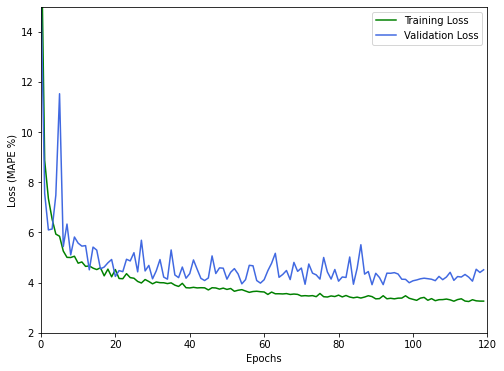

In [ ]:
# history_list[-1].history.keys()
# len(history_list[-1].history['loss'])
length = len(history_list[-1].history['loss'])
x = range(length)
loss = history_list[-1].history['loss']
val_loss = history_list[-1].history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(x, loss, color='Green')  # train loss
plt.plot(val_loss, color='RoyalBlue')  # val loss
plt.legend(['Training Loss', 'Validation Loss'])
plt.axis([0, length, 2, 15])
plt.xlabel('Epochs')
plt.ylabel('Loss (MAPE %)')
plt.show()

In the following cell, we further visualize our forecast performacne on the test year 2007. We can tell that our model prediction is fairly close to the actual load curve. 

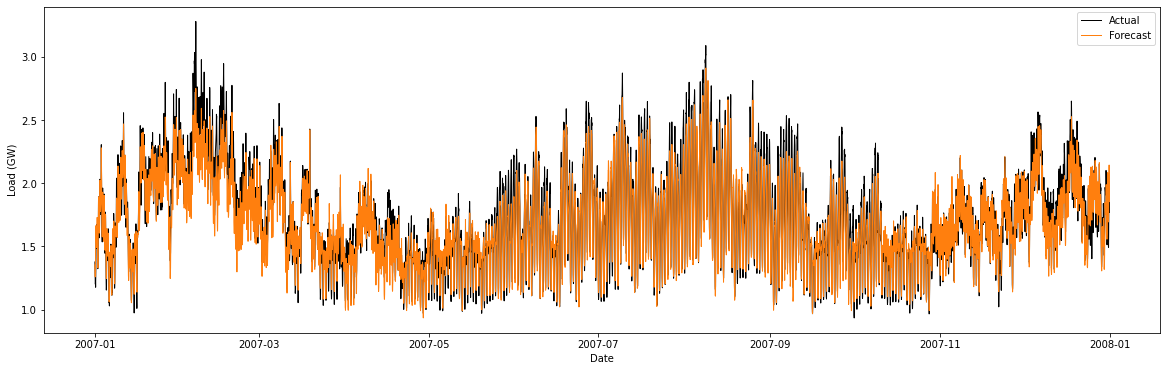

In [ ]:
t = pd.DataFrame({'date': pd.date_range(datetime(2007, 1, 1), datetime(2007, 12, 31, 23), freq="H")})  # 2007

plt.figure(figsize=(20, 6))
plt.plot(t, test.load*3, lw=1, c='black', label='Actual')
plt.plot(t, fcst_full*3, lw=1, c='tab:orange', label='Forecast')
plt.ylabel('Load (GW)')
plt.xlabel('Date')
plt.legend()
plt.show()

## Network 2


The following cell gives the settings of our second network. We have 51 input neurons for 51 input features. we have 6 fully-connected hidden layers, each with 27 hidden neurons. We recompile the network 5 times to ensure different initial conditions have been tried out and each network will generate a forecast on the test year. At the end, we average the forecasts generated from the 5 different initial conditions. The rest settings have been following as mentioned in the previous cells. 

From the output of the following cell, we can tell that the training halts mostly at 50-100 epochs, even though we set the maximum epoch to be 300. After 50 epochs, the validation loss has rarely been reduced. 

In [ ]:
n_input = len(X_train.columns) # 51
layer_num = 6
n_hidden_1 = 27  # node num of layer 1
n_hidden_2 = 27  # node num of layer 2 and beyond
num_repeat = 5
batch_size = 32
verbose = 0

def recompile():
    model = Sequential()
    model.add(Dense(n_hidden_1, input_dim=n_input, activation='selu', kernel_initializer='lecun_normal'))
    for i in range(layer_num - 1):
        model.add(Dense(n_hidden_2, activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(1)) # output neuron
    model.compile(loss=mean_absolute_percentage_error, optimizer='adam')
    return model


mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    pred = saved_model.predict(X_test_pred)  # predict on test set using the snapshot 1 trained model
    pred = pred.reshape(24 * 365)
    pred_list.append(pred)

fcst_full = np.mean(pred_list, axis=0)  # compress(average) 10 rows into one row

Epoch 00070: early stopping
repeat time=1 MAPE on Training set: 3.492, MAPE on Validation set: 3.818
Epoch 00125: early stopping
repeat time=2 MAPE on Training set: 3.082, MAPE on Validation set: 3.828
Epoch 00068: early stopping
repeat time=3 MAPE on Training set: 3.504, MAPE on Validation set: 3.862
Epoch 00061: early stopping
repeat time=4 MAPE on Training set: 3.940, MAPE on Validation set: 3.852
Epoch 00065: early stopping
repeat time=5 MAPE on Training set: 3.381, MAPE on Validation set: 4.126


In the following cell, we evaluate our final forecast and get the MAPE performance on the training, validation and test set, respectively.

In [ ]:
print(f'The MAPE on the training set is {np.mean(mape_train):.3f}')
print(f'The MAPE on the validation set is {np.mean(mape_valid):.3f}')
print(f'The MAPE on out-of-sample test is {MAPE(y_test, fcst_full):.3f}')

The MAPE on the training set is 3.480
The MAPE on the validation set is 3.897
The MAPE on out-of-sample test is 4.589


We then visualize our training performance using the last repeating trial of the training. From the plot below, we can tell that although the training loss keeps decreasing, the validation loss stops decreasing after about 50 epochs. Our early stopping has enforced the training process to halt if we could not observe lower validation loss after 30 epochs. 

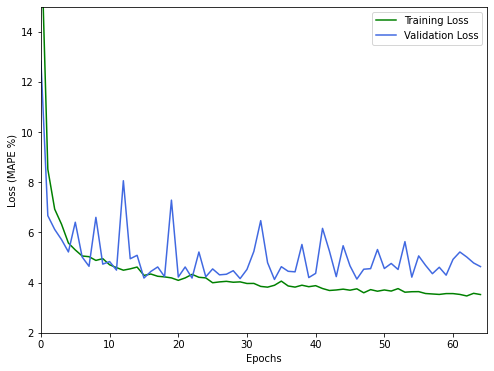

In [ ]:
# history_list[-1].history.keys()
# len(history_list[-1].history['loss'])
length = len(history_list[-1].history['loss'])
x = range(length)
loss = history_list[-1].history['loss']
val_loss = history_list[-1].history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(x, loss, color='Green')  # train loss
plt.plot(val_loss, color='RoyalBlue')  # val loss
plt.legend(['Training Loss', 'Validation Loss'])
plt.axis([0, length, 2, 15])
plt.xlabel('Epochs')
plt.ylabel('Loss (MAPE %)')
plt.show()

In the following cell, we further visualize our forecast performacne on the test year 2007. We can tell that our model prediction is fairly close to the actual load curve. We couldn't tell much difference between the network 2 and 1. 

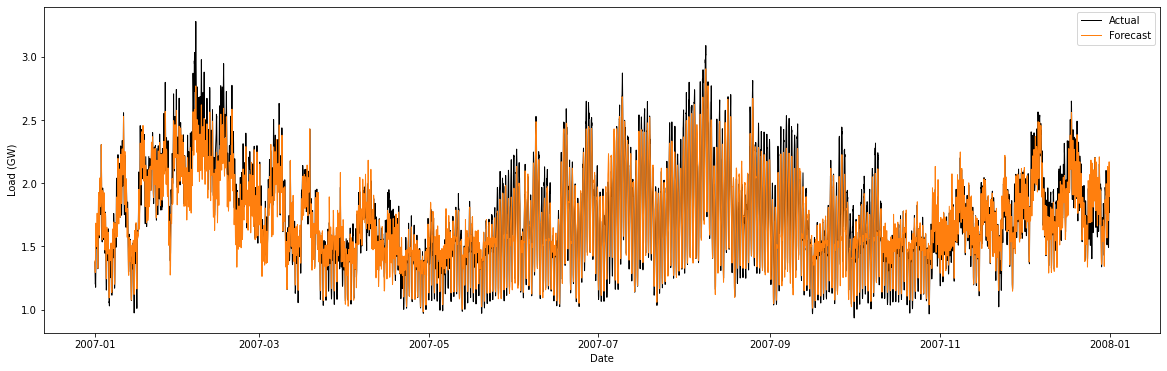

In [ ]:
t = pd.DataFrame({'date': pd.date_range(datetime(2007, 1, 1), datetime(2007, 12, 31, 23), freq="H")})  # 2007

plt.figure(figsize=(20, 6))
plt.plot(t, test.load*3, lw=1, c='black', label='Actual')
plt.plot(t, fcst_full*3, lw=1, c='tab:orange', label='Forecast')
plt.ylabel('Load (GW)')
plt.xlabel('Date')
plt.legend()
plt.show()

## Network 3


The following cell gives the settings of our third network. We have the same number of input neurons as the 1st and 2nd network and have 7 fully-connected hidden layers, each with 23 hidden neurons. We recompile the network 5 times to ensure different initial conditions have been tried out and each network will generate a forecast on the test year. At the end, we average the forecasts generated from the 5 different initial conditions. The rest settings have been following as mentioned in the previous cells. 

From the output of the following cell, we can tell that the training halts mostly at 50-100 epochs, even though we set the maximum epoch to be 300. After 50 epochs, the validation loss has rarely been reduced. 

In [ ]:
n_input = len(X_train.columns) # 51
layer_num = 7
n_hidden_1 = 23  # node num of layer 1
n_hidden_2 = 23  # node num of layer 2 and beyond
num_repeat = 5
batch_size = 32
verbose = 0

def recompile():
    model = Sequential()
    model.add(Dense(n_hidden_1, input_dim=n_input, activation='selu', kernel_initializer='lecun_normal'))
    for i in range(layer_num - 1):
        model.add(Dense(n_hidden_2, activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(1)) # output neuron
    model.compile(loss=mean_absolute_percentage_error, optimizer='adam')
    return model


mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    pred = saved_model.predict(X_test_pred)  # predict on test set using the snapshot 1 trained model
    pred = pred.reshape(24 * 365)
    pred_list.append(pred)

fcst_full = np.mean(pred_list, axis=0)  # compress(average) 10 rows into one row

Epoch 00101: early stopping
repeat time=1 MAPE on Training set: 3.639, MAPE on Validation set: 3.712
Epoch 00079: early stopping
repeat time=2 MAPE on Training set: 3.786, MAPE on Validation set: 3.809
Epoch 00107: early stopping
repeat time=3 MAPE on Training set: 3.225, MAPE on Validation set: 3.938
Epoch 00050: early stopping
repeat time=4 MAPE on Training set: 3.778, MAPE on Validation set: 3.888
Epoch 00059: early stopping
repeat time=5 MAPE on Training set: 3.656, MAPE on Validation set: 4.027


In the following cell, we evaluate our final forecast and get the MAPE performance on the training, validation and test set, respectively.

In [ ]:
print(f'The MAPE on the training set is {np.mean(mape_train):.3f}')
print(f'The MAPE on the validation set is {np.mean(mape_valid):.3f}')
print(f'The MAPE on out-of-sample test is {MAPE(y_test, fcst_full):.3f}')

The MAPE on the training set is 3.617
The MAPE on the validation set is 3.875
The MAPE on out-of-sample test is 4.591


We then visualize our training performance using the last repeating trial of the training. From the plot below, we can tell that although the training loss keeps decreasing, the validation loss stops decreasing after about 50 epochs. Our early stopping has enforced the training process to halt if we could not observe lower validation loss after 30 epochs. 

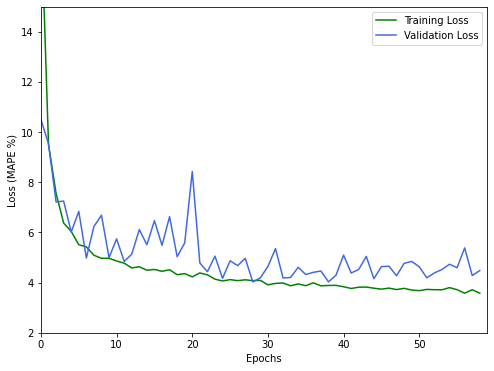

In [ ]:
# history_list[-1].history.keys()
# len(history_list[-1].history['loss'])
length = len(history_list[-1].history['loss'])
x = range(length)
loss = history_list[-1].history['loss']
val_loss = history_list[-1].history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(x, loss, color='Green')  # train loss
plt.plot(val_loss, color='RoyalBlue')  # val loss
plt.legend(['Training Loss', 'Validation Loss'])
plt.axis([0, length, 2, 15])
plt.xlabel('Epochs')
plt.ylabel('Loss (MAPE %)')
plt.show()

In the following cell, we further visualize our forecast performacne on the test year 2007. We can tell that our model prediction is fairly close to the actual load curve. We couldn't tell much difference between the network 2 and 1. 

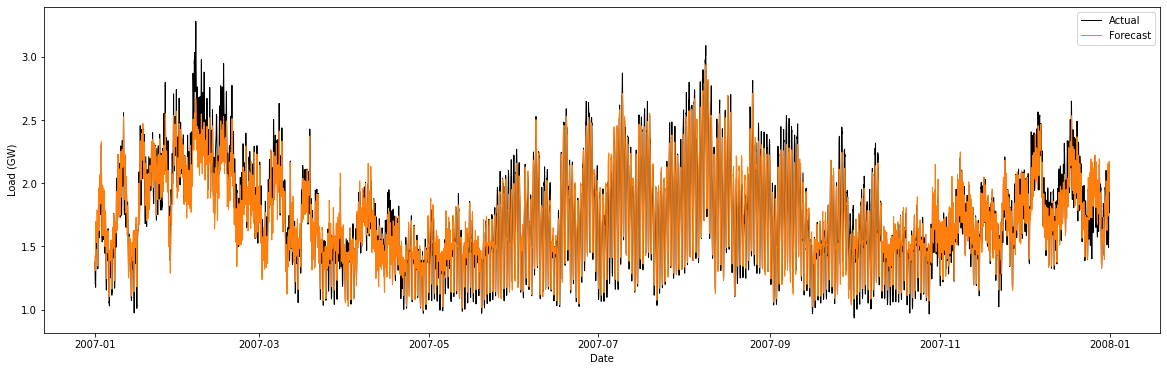

In [ ]:
t = pd.DataFrame({'date': pd.date_range(datetime(2007, 1, 1), datetime(2007, 12, 31, 23), freq="H")})  # 2007

plt.figure(figsize=(20, 6))
plt.plot(t, test.load*3, lw=1, c='black', label='Actual')
plt.plot(t, fcst_full*3, lw=1, c='tab:orange', label='Forecast')
plt.ylabel('Load (GW)')
plt.xlabel('Date')
plt.legend()
plt.show()

# IV. Results

#### Presents the result of Your Applications of your deep Network

**We have visualized the training performance and the forecast output in the last section**. From Section III, we also notice that the training epochs of all 3 networks halts mostly at 50-100 epochs for all three networks, even though we set the maximum epoch to be 300. Such a fact suggests that after 50 epochs, the historical minimum of validation loss has rarely been updated for all the networks.

We further use a table below summarizes the MAPE on the training, validation and test set for each network. Our findings are twofold:
1.   The 1st network gives the lowest training error, while it results in the highest errors on validation and test set. This implies that the "shallower" network we implement in this assignment seems to be more vulnerable to the overfitting issue.
2.   The 2nd and 3rd network gives fairly close forecasting errors on the validation and test sets, even though the average training error on the 3rd network is higher than the other two. 

To summarize, given roughly the same number of total hidden neurons, the deeper network leads to superior out-of-sample performance than the shallowest one. The deeper network takes about the same training epochs to converge as the shallowest one. 

It may also imply that at a certain point, increasing the number of hidden layers may not give much out-of-sample performance boost (from the 2nd to the 3rd network), while further experiments needs to be made to confirm this finding. 



| Structure | Training MAPE (%) | Validation MAPE (%) | Test MAPE (%) |
|:--- |:---:|:---:|:---:|
| Network 1 | **3.437** | 3.993 | 4.785 |
| Network 2 | 3.480 | 3.897 | **4.589** |
| Network 3 | 3.617 | **3.875** | 4.591 |

# V. Conclusion

In this assignment I gained deeper knowledge about the implementation of deep learning and DNN. The main challenge for me was to select the right procedure to avoid overfitting given a network structure and ensure robust out-of-sample performance. We chose the early stopping class in Keras to tackle this issue. I also found Google Colab to be an excellent tool to experiment deep learning models since it's fast and easy to use. 

For the experiments, we tried out 3 deep networks with roughly the same number of total hidden neurons. The results show that all 3 networks led to good load forecasts with a MAPE of around 4.6-4.7%. We notice that given roughly the same number of total hidden neurons, the deeper network leads to superior out-of-sample performance than the shallowest one. Meanwhile, the deeper network seems to take about the same training epochs to converge as the shallowest one. 


# VI. References

(1). GEFCom2012 data. Retrieved from http://blog.drhongtao.com/2016/07/gefcom2012-load-forecasting-data.html




# Grading

Only well-written notebook will be graded. Please follow the structure and fill in as the other assignments. 

extra credit points | description
--|:--
1 | First structure (implementation, explanation, plot results, discussion of results)
1 | Second structure (implementation, explanation, plot results, discussion of results)
1 | Third structure (implementation, explanation, plot results, discussion of results)
1 | Explaining and discussing the reason for the selection (Any relation to your data?)
  | Comparing the results, discuss or verify your choice 

#### Optional Extra Credits

- [OPT 1] Test your program with GPUs and compare training speed. You can try [FloydHub](https://www.floydhub.com/) for free 2 hours of GPU resources or MAMBA cluster for this test. 
- [OPT 2] Implement one of neural networks in the chart above and apply it to some real data. 


There are a lot of different neural networks as you see in the figure below. The image is just for your reference but you **are not required** to implement any other types of neurons such as LSTM, CNN, etc. You are fine to use basic neurons with different number of layers and hidden units to fulfil the requirement of this assignment.

<img src="https://camo.githubusercontent.com/31e20172e3b7bc5530a6e7c7e7339e8e556d0acc/687474703a2f2f7777772e6173696d6f76696e737469747574652e6f72672f77702d636f6e74656e742f75706c6f6164732f323031362f30392f6e657572616c6e6574776f726b732e706e67" width=700 />



**We took the OPT1 and test the execution time (per epoch) with CPU and GPU.**

**We leverage the computation source from Google Colab to conduct the experiment for the GPU part.**

## Run with CPU
First, we ran my programs by CPU. We created a class called `TimeHistory` and this will serve as the callback to record the execution time (in seconds) for each epoch. Then we simply average the time for the epochs to get the execution time with CPU.

### Network 1

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from datetime import datetime
import time

n_input = len(X_train.columns) # 51
layer_num = 5
n_hidden_1 = 32  # node num of layer 1
n_hidden_2 = 32  # node num of layer 2 and beyond
num_repeat = 1
batch_size = 32
verbose = 0

def MAPE(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def recompile():
    model = Sequential()
    model.add(Dense(n_hidden_1, input_dim=n_input, activation='selu', kernel_initializer='lecun_normal'))
    for i in range(layer_num - 1):
        model.add(Dense(n_hidden_2, activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(1)) # output neuron
    model.compile(loss=mean_absolute_percentage_error, optimizer='adam')
    return model

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    time_callback = TimeHistory()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc, time_callback], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    times = time_callback.times

Epoch 00081: early stopping
repeat time=1 MAPE on Training set: 3.196, MAPE on Validation set: 3.937


In [18]:
print(f'Average time (per epoch) on the Network 1: {np.mean(times):.3f} seconds')

Average time (per epoch) on the Network 1: 0.780 seconds


### Network 2

In [19]:
n_input = len(X_train.columns) # 51
layer_num = 6
n_hidden_1 = 27  # node num of layer 1
n_hidden_2 = 27  # node num of layer 2 and beyond
num_repeat = 1
batch_size = 32
verbose = 0

mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    time_callback = TimeHistory()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc, time_callback], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    times = time_callback.times

Epoch 00059: early stopping
repeat time=1 MAPE on Training set: 3.995, MAPE on Validation set: 3.953


In [20]:
print(f'Average time (per epoch) on the Network 2: {np.mean(times):.3f} seconds')

Average time (per epoch) on the Network 2: 0.796 seconds


### Network 3

In [21]:
n_input = len(X_train.columns) # 51
layer_num = 7
n_hidden_1 = 23  # node num of layer 1
n_hidden_2 = 23  # node num of layer 2 and beyond
num_repeat = 1
batch_size = 32
verbose = 0

mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    time_callback = TimeHistory()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc, time_callback], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    times = time_callback.times

Epoch 00079: early stopping
repeat time=1 MAPE on Training set: 4.093, MAPE on Validation set: 4.016


In [22]:
print(f'Average time (per epoch) on the Network 3: {np.mean(times):.3f} seconds')

Average time (per epoch) on the Network 3: 0.814 seconds


## Run with GPU

Then we repeat our experiments using GPU from Google Colab.

### Network 1

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from datetime import datetime
import time

n_input = len(X_train.columns) # 51
layer_num = 5
n_hidden_1 = 32  # node num of layer 1
n_hidden_2 = 32  # node num of layer 2 and beyond
num_repeat = 1
batch_size = 32
verbose = 0

def MAPE(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true).flatten(), np.asarray(y_pred).flatten()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def recompile():
    model = Sequential()
    model.add(Dense(n_hidden_1, input_dim=n_input, activation='selu', kernel_initializer='lecun_normal'))
    for i in range(layer_num - 1):
        model.add(Dense(n_hidden_2, activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(1)) # output neuron
    model.compile(loss=mean_absolute_percentage_error, optimizer='adam')
    return model

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    time_callback = TimeHistory()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc, time_callback], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    times = time_callback.times

Epoch 00003: early stopping
repeat time=1 MAPE on Training set: 5.912, MAPE on Validation set: 6.668


In [17]:
print(f'Average time (per epoch) on the Network 1: {np.mean(times):.3f} seconds')

Average time (per epoch) on the Network 1: 1.740 seconds


### Network 2

In [18]:
n_input = len(X_train.columns) # 51
layer_num = 6
n_hidden_1 = 27  # node num of layer 1
n_hidden_2 = 27  # node num of layer 2 and beyond
num_repeat = 1
batch_size = 32
verbose = 0

mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    time_callback = TimeHistory()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc, time_callback], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    times = time_callback.times

Epoch 00003: early stopping
repeat time=1 MAPE on Training set: 7.070, MAPE on Validation set: 7.355


In [19]:
print(f'Average time (per epoch) on the Network 2: {np.mean(times):.3f} seconds')

Average time (per epoch) on the Network 2: 1.811 seconds


### Network 3

In [20]:
n_input = len(X_train.columns) # 51
layer_num = 7
n_hidden_1 = 23  # node num of layer 1
n_hidden_2 = 23  # node num of layer 2 and beyond
num_repeat = 1
batch_size = 32
verbose = 0

mape_train = []  # list to store MAPE train
mape_valid = []  # list to store MAPE validation
history_list = []  # stores snapshot fitted models
pred_list = []  # list to store predictions for the test year (365 days)

predictor = X_train
response = y_train
validation_data = (X_val, y_val)
X_test_pred = X_test

for i in range(num_repeat):
    model = recompile()
    time_callback = TimeHistory()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)  # patient early stopping
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    history = model.fit(predictor, response, epochs=300, batch_size=batch_size, validation_data=validation_data,
                          callbacks=[es, mc, time_callback], verbose=verbose)
    history_list.append(history)
    saved_model = load_model('best_model.h5')
    # evaluate the model
    train_acc = saved_model.evaluate(X_train, y_train, verbose=0)  # predict on training set
    mape_train.append(train_acc)
    valid_acc = saved_model.evaluate(X_val, y_val, verbose=0)  # predict on validation set
    mape_valid.append(valid_acc)
    print(f'repeat time={i + 1}', 'MAPE on Training set: %.3f, MAPE on Validation set: %.3f' % (train_acc, valid_acc))

    times = time_callback.times

Epoch 00003: early stopping
repeat time=1 MAPE on Training set: 7.804, MAPE on Validation set: 8.318


In [21]:
print(f'Average time (per epoch) on the Network 3: {np.mean(times):.3f} seconds')

Average time (per epoch) on the Network 3: 1.834 seconds


## Summary of CPU vs. GPU results

We summarize our findings in the table below. Surprisingly, we found out the GPU execution time is over twice as longer than CPU per epoch. This is probably due to two reasons:
- the Google Colab has better optimization on its CPU
- our network is not deep enough to show the advantage of using GPU

We also notice that as our network become deeper, the per epoch execution time is longer for both the CPU and GPU options. This is because we are having more parameters to estimate. 

| Structure | CPU Per Epoch Exec Time (sec) | GPU Per Epoch Exec Time (sec) |
|:--- |:---:|:---:|
| Network 1 | 0.780 | 1.740 |
| Network 2 | 0.796 | 1.811 |
| Network 3 | 0.814 | 1.834 |